Hi, Kagglers!

Hereafter I will try to reveal some basics about Instacart dataset <br>**by conducting an exploratory data analysis of given Dataset**

**Brief description**

The Dataset is an anonymized sample of over 3,000,000 grocery orders from more than 200,000 Instacart users. 
<br>The goal of a competition is to predict which previously purchased products will be in a user’s next order. 

### Stay tuned, this notebook will be updated on a regular basis
**P.s. Upvotes and comments would let me update it faster and in a more smart way :)**

## Load Libraries

In [1]:
import pandas as pd # dataframes
import numpy as np # algebra & calculus
import nltk # text preprocessing & manipulation
# from textblob import TextBlob
import matplotlib.pyplot as plt # plotting
import seaborn as sns # plotting

from functools import partial # to reduce df memory consumption by applying to_numeric

color = sns.color_palette() # adjusting plotting style
import warnings
warnings.filterwarnings('ignore') # silence annoying warnings

%matplotlib inline

## Datasets ER-Model (<a href="https://www.kaggle.com/c/instacart-market-basket-analysis/discussion/33128#183176">See this discussion</a>)
![ER-Model][1]
## Load Datasets
### Descriptive datasets


  [1]: https://kaggle2.blob.core.windows.net/forum-message-attachments/183176/6539/instacartFiles.png

In [2]:
# aisles
aisles = pd.read_csv('../input/aisles.csv', engine='c')
print('Total aisles: {}'.format(aisles.shape[0]))
aisles.head()

Total aisles: 134


,aisle_id,aisle
0,1,prepared soups salads
1,2,specialty cheeses
2,3,energy granola bars
3,4,instant foods
4,5,marinades meat preparation


In [3]:
# departments
departments = pd.read_csv('../input/departments.csv', engine='c')
print('Total departments: {}'.format(departments.shape[0]))
departments.head()

Total departments: 21


,department_id,department
0,1,frozen
1,2,other
2,3,bakery
3,4,produce
4,5,alcohol


In [4]:
# products
products = pd.read_csv('../input/products.csv', engine='c')
print('Total products: {}'.format(products.shape[0]))
products.head(5)

Total products: 49688


,product_id,product_name,aisle_id,department_id
0,1,Chocolate Sandwich Cookies,61,19
1,2,All-Seasons Salt,104,13
2,3,Robust Golden Unsweetened Oolong Tea,94,7
3,4,Smart Ones Classic Favorites Mini Rigatoni Wit...,38,1
4,5,Green Chile Anytime Sauce,5,13


### Combine it all together into 1 DataFrame "GOODS"

In [5]:
# combine aisles, departments and products (left joined to products)
goods = pd.merge(left=pd.merge(left=products, right=departments, how='left'), right=aisles, how='left')
# to retain '-' and make product names more "standard"
goods.product_name = goods.product_name.str.replace(' ', '_').str.lower() 

goods.head()

,product_id,product_name,aisle_id,department_id,department,aisle
0,1,chocolate_sandwich_cookies,61,19,snacks,cookies cakes
1,2,all-seasons_salt,104,13,pantry,spices seasonings
2,3,robust_golden_unsweetened_oolong_tea,94,7,beverages,tea
3,4,smart_ones_classic_favorites_mini_rigatoni_wit...,38,1,frozen,frozen meals
4,5,green_chile_anytime_sauce,5,13,pantry,marinades meat preparation


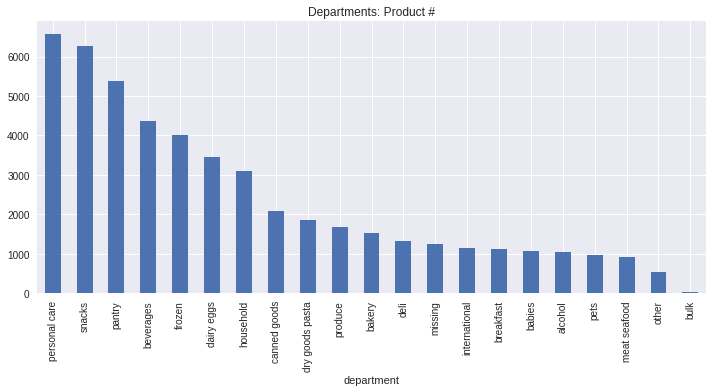

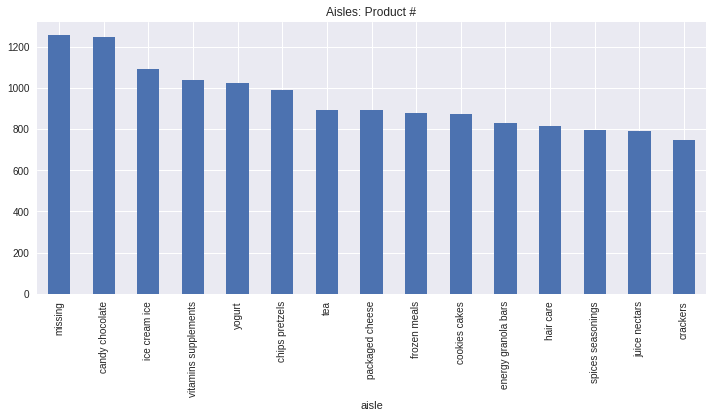

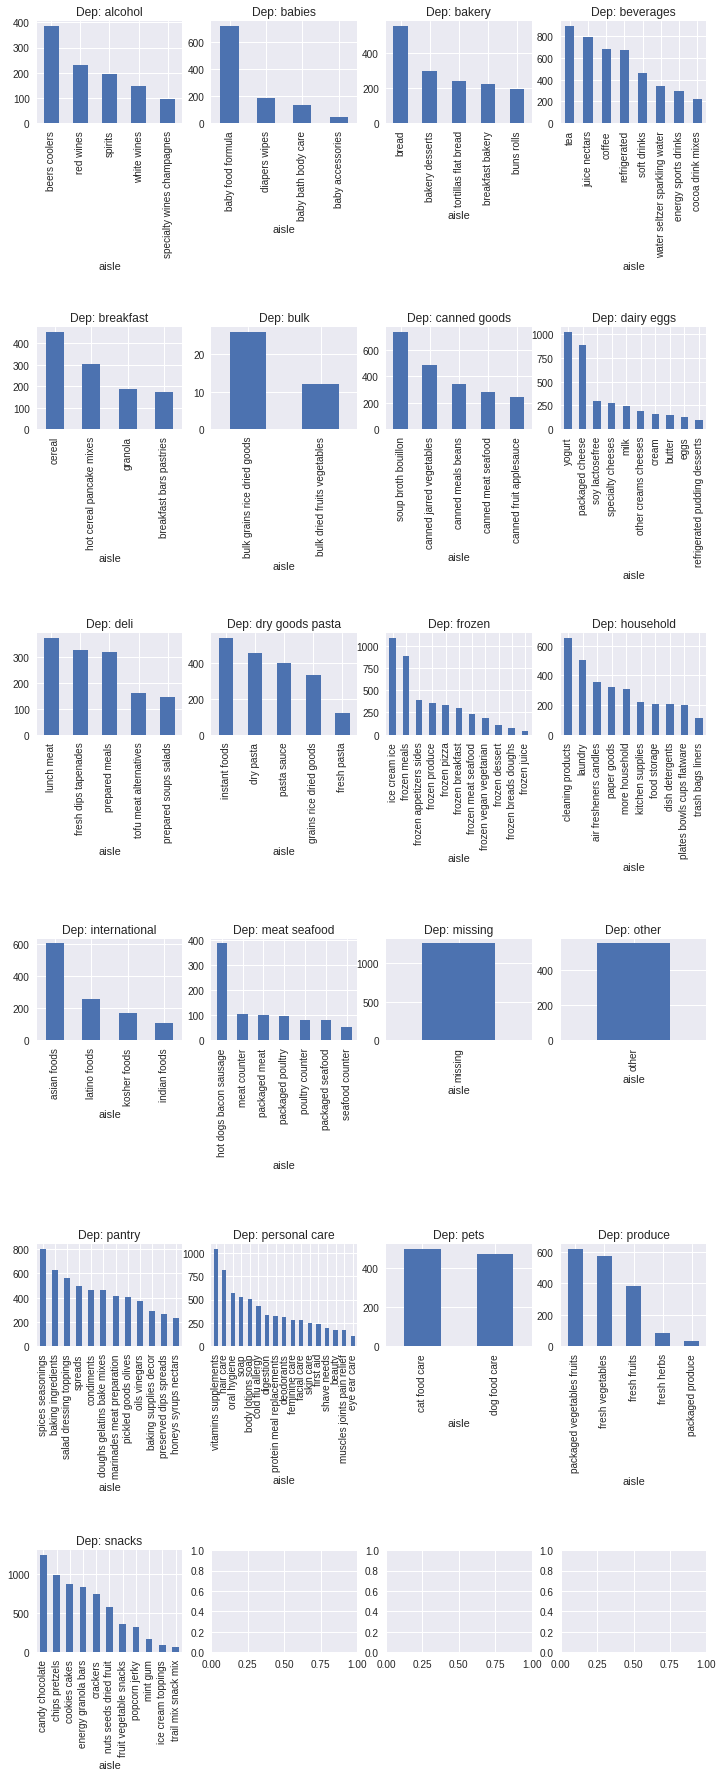

In [6]:
# basic group info (departments)
plt.figure(figsize=(12, 5))
goods.groupby(['department']).count()['product_id'].copy()\
.sort_values(ascending=False).plot(kind='bar', 
                                   #figsize=(12, 5), 
                                   title='Departments: Product #')


# basic group info (top-x aisles)
top_aisles_cnt = 15
plt.figure(figsize=(12, 5))
goods.groupby(['aisle']).count()['product_id']\
.sort_values(ascending=False)[:top_aisles_cnt].plot(kind='bar', 
                                   #figsize=(12, 5), 
                                   title='Aisles: Product #')

# plot departments volume, split by aisles
f, axarr = plt.subplots(6, 4, figsize=(12, 30))
for i,e in enumerate(departments.department.sort_values(ascending=True)):
    axarr[i//4, i%4].set_title('Dep: {}'.format(e))
    goods[goods.department==e].groupby(['aisle']).count()['product_id']\
    .sort_values(ascending=False).plot(kind='bar', ax=axarr[i//4, i%4])
f.subplots_adjust(hspace=2)

### To my regret, Python lacks good treemap packages - <br>That's why I embedded a link to gorgeous R visualizations from <a href="https://www.kaggle.com/philippsp/first-exploratory-analysis">This Kernel</a>

### Visualizing the Product Portfolio

**How are aisles organized within departments?**
![within_departments][1]

  [1]: https://www.kaggle.io/svf/1167770/471bab8e222cd6e1e823d080a6980e8a/__results___files/figure-html/unnamed-chunk-24-1.png

**How many unique products are offered in each department/aisle?**
![unique_products][1]

  [1]: https://www.kaggle.io/svf/1167770/471bab8e222cd6e1e823d080a6980e8a/__results___files/figure-html/unnamed-chunk-25-1.png

**How often are products from the department/aisle sold?**

![sold_amount][1]

  [1]: https://www.kaggle.io/svf/1167770/471bab8e222cd6e1e823d080a6980e8a/__results___files/figure-html/unnamed-chunk-26-1.png

## Main Datasets (orders + order details)

In [7]:
# load datasets

# train dataset
op_train = pd.read_csv('../input/order_products__train.csv', engine='c', 
                       dtype={'order_id': np.int32, 'product_id': np.int32, 
                              'add_to_cart_order': np.int16, 'reordered': np.int8})
print('Total ordered products(train): {}'.format(op_train.shape[0]))
op_train.head(10)

Total ordered products(train): 1384617


,order_id,product_id,add_to_cart_order,reordered
0,1,49302,1,1
1,1,11109,2,1
2,1,10246,3,0
3,1,49683,4,0
4,1,43633,5,1
5,1,13176,6,0
6,1,47209,7,0
7,1,22035,8,1
8,36,39612,1,0
9,36,19660,2,1


In [8]:
# test dataset (submission)
test = pd.read_csv('../input/sample_submission.csv', engine='c')
print('Total orders(test): {}'.format(op_train.shape[0]))
test.head()

Total orders(test): 1384617


,order_id,products
0,17,39276
1,34,39276
2,137,39276
3,182,39276
4,257,39276


In [9]:
# prior dataset
op_prior = pd.read_csv('../input/order_products__prior.csv', engine='c', 
                       dtype={'order_id': np.int32, 'product_id': np.int32, 
                              'add_to_cart_order': np.int16, 'reordered': np.int8})
print('Total ordered products(prior): {}'.format(op_prior.shape[0]))
op_prior.head()

Total ordered products(prior): 32434489


,order_id,product_id,add_to_cart_order,reordered
0,2,33120,1,1
1,2,28985,2,1
2,2,9327,3,0
3,2,45918,4,1
4,2,30035,5,0


In [10]:
# orders
orders = pd.read_csv('../input/orders.csv', engine='c', dtype={'order_id': np.int32, 
                                                           'user_id': np.int32, 
                                                           'order_number': np.int32, 
                                                           'order_dow': np.int8, 
                                                           'order_hour_of_day': np.int8, 
                                                           'days_since_prior_order': np.float16})
print('Total orders: {}'.format(orders.shape[0]))
orders.head()

Total orders: 3421083


,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2539329,1,prior,1,2,8,NaN
1,2398795,1,prior,2,3,7,15.0
2,473747,1,prior,3,3,12,21.0
3,2254736,1,prior,4,4,7,29.0
4,431534,1,prior,5,4,15,28.0


### Combine (orders, order details, product hierarchy) into 1 dataframe order_details 
**(be careful, high memory consumption, about 3GB RAM itself)**

In [11]:
from functools import partial

# merge train and prior together iteratively, to fit into 8GB kernel RAM
# split df indexes into parts
indexes = np.linspace(0, len(op_prior), num=10, dtype=np.int32)

# initialize it with train dataset
order_details = pd.merge(
                left=op_train,
                 right=orders, 
                 how='left', 
                 on='order_id'
        ).apply(partial(pd.to_numeric, errors='ignore', downcast='integer'))

# add order hierarchy
order_details = pd.merge(
                left=order_details,
                right=goods[['product_id', 
                             'aisle_id', 
                             'department_id']].apply(partial(pd.to_numeric, 
                                                             errors='ignore', 
                                                             downcast='integer')),
                how='left',
                on='product_id'
)

print(order_details.shape, op_train.shape)

# delete (redundant now) dataframes
del op_train

order_details.head()

(1384617, 12) (1384617, 4)


,order_id,product_id,add_to_cart_order,reordered,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,aisle_id,department_id
0,1,49302,1,1,112108,train,4,4,10,9,120,16
1,1,11109,2,1,112108,train,4,4,10,9,108,16
2,1,10246,3,0,112108,train,4,4,10,9,83,4
3,1,49683,4,0,112108,train,4,4,10,9,83,4
4,1,43633,5,1,112108,train,4,4,10,9,95,15


In [12]:
%%time
# update by small portions
for i in range(len(indexes)-1):
    order_details = pd.concat(
        [   
            order_details,
            pd.merge(left=pd.merge(
                            left=op_prior.iloc[indexes[i]:indexes[i+1], :],
                            right=goods[[
                                'product_id', 
                                 'aisle_id', 
                                 'department_id'
                            ]].apply(partial(pd.to_numeric, 
                                             errors='ignore', 
                                             downcast='integer')),
                            how='left',
                            on='product_id'
                            ),
                     right=orders, 
                     how='left', 
                     on='order_id'
                ) #.apply(partial(pd.to_numeric, errors='ignore', downcast='integer'))
        ]
    )
        
print('Datafame length: {}'.format(order_details.shape[0]))
print('Memory consumption: {:.2f} Mb'.format(sum(order_details.memory_usage(index=True, 
                                                                         deep=True) / 2**20)))
# check dtypes to see if we use memory effectively
print(order_details.dtypes)

# make sure we didn't forget to retain test dataset :D
test_orders = orders[orders.eval_set == 'test']

# delete (redundant now) dataframes
del op_prior, orders

Datafame length: 33819106
Memory consumption: 3096.23 Mb
add_to_cart_order           int16
aisle_id                    int16
days_since_prior_order    float16
department_id                int8
eval_set                   object
order_dow                    int8
order_hour_of_day            int8
order_id                    int32
order_number                int32
product_id                  int32
reordered                    int8
user_id                     int32
dtype: object
CPU times: user 28.4 s, sys: 45.7 s, total: 1min 14s
Wall time: 1min 14s


In [13]:
%%time
# unique orders, product_ordered, users
print('Unique users: {}'.format(len(set(order_details.user_id))))
print('Unique orders: {}'.format(len(set(order_details.order_id))))
print('Unique products bought: {}/{}'.format(len(set(order_details.product_id)), len(goods)))

Unique users: 206209
Unique orders: 3346083
Unique products bought: 49685/49688
CPU times: user 8.73 s, sys: 456 ms, total: 9.18 s
Wall time: 9.15 s


In [14]:
# unordered products
unordered = goods[goods.product_id.isin(list(set(goods.product_id) - set(order_details.product_id)))]
print('"Lonesome" products cnt: {}/{}'.format(unordered.shape[0], len(goods)))
unordered.head()

"Lonesome" products cnt: 3/49688


,product_id,product_name,aisle_id,department_id,department,aisle
3629,3630,protein_granola_apple_crisp,57,14,breakfast,granola
7044,7045,unpeeled_apricot_halves_in_heavy_syrup,88,13,pantry,spreads
46624,46625,single_barrel_kentucky_straight_bourbon_whiskey,31,7,beverages,refrigerated


### Popular Products (Bestsellers)

CPU times: user 12.5 s, sys: 9.76 s, total: 22.3 s
Wall time: 22.3 s


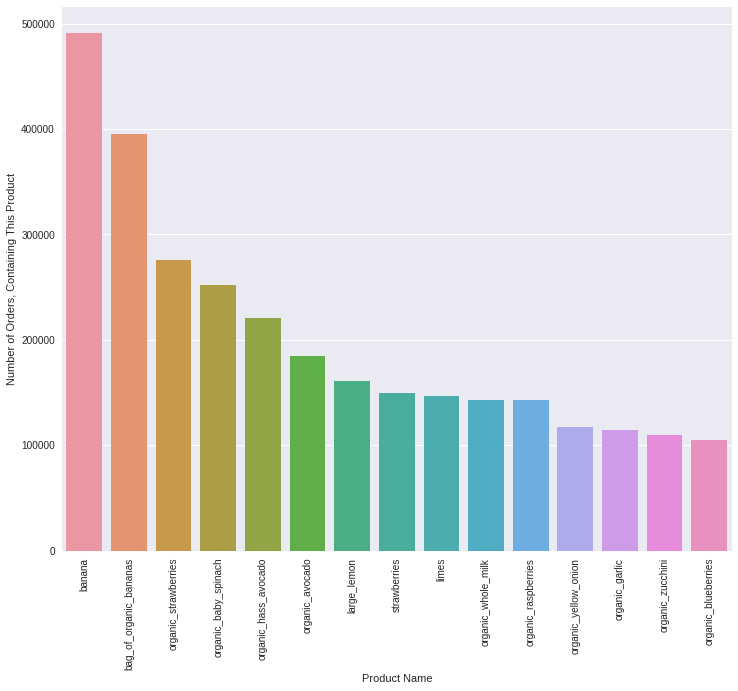

In [15]:
%%time
# popular products (total set, not only train)
top = 15
top_products = pd.merge(
    # to see train: 
    # left=pd.DataFrame(order_details[order_details.eval_set == 'train'].groupby(['product_id'])['order_id']\
    left=pd.DataFrame(order_details.groupby(['product_id'])['order_id']\
    .apply(lambda x: len(x.unique())).sort_values(ascending=False)[:top].reset_index('product_id')),
    right=goods,
    how='left')

f, ax = plt.subplots(figsize=(12, 10))
plt.xticks(rotation='vertical')
sns.barplot(top_products.product_name, top_products.order_id)
plt.ylabel('Number of Orders, Containing This Product')
plt.xlabel('Product Name')

### Most "Frequently" Bought Products

CPU times: user 9.22 s, sys: 7.99 s, total: 17.2 s
Wall time: 17.2 s


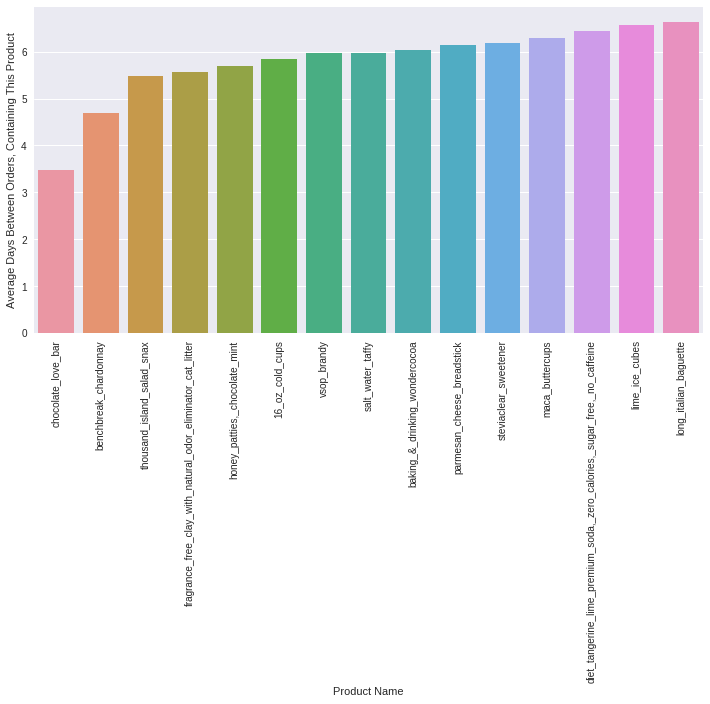

In [16]:
%%time
# most "frequently" bought products (total set, not only train)
# most "frequently" ~ time between orders (within selected customer's orders), 
# that contain that product, is the least 
#(products, which were bought by more than 100 customers, to omit outliers)
top = 15
customer_limit = 100

temp = order_details.groupby(['product_id'])[['days_since_prior_order', 'user_id']]\
.aggregate({'days_since_prior_order': np.mean, 'user_id': len}).reset_index()

frequent_products = pd.merge(
    left=pd.DataFrame(temp[temp.user_id > customer_limit].sort_values(['days_since_prior_order'], 
                                                                      ascending=True)[:top]),
    right=goods,
    how='left')

plt.figure(figsize=(12,6))
plt.xticks(rotation='vertical')
sns.barplot(frequent_products.product_name, frequent_products.days_since_prior_order)
plt.ylabel('Average Days Between Orders, Containing This Product')
plt.xlabel('Product Name')

del temp

### Orders, Split by Product Count

Most common order contains: 5 products
CPU times: user 1.89 s, sys: 4.63 s, total: 6.52 s
Wall time: 6.51 s


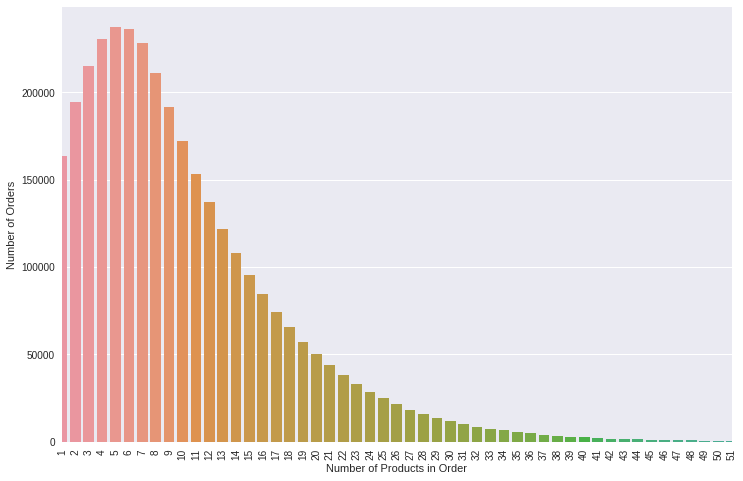

In [17]:
%%time
ord_by_prods = order_details.groupby("order_id")["add_to_cart_order"]\
.aggregate(np.max).reset_index()['add_to_cart_order'].value_counts()

print('Most common order contains: {} products'.format(
    ord_by_prods[ord_by_prods.values == ord_by_prods.max()].index.values[0]))

# plot it
plt.figure(figsize=(12, 8))
plt.xticks(rotation='vertical')
sns.barplot(ord_by_prods.index, ord_by_prods.values)
plt.ylabel('Number of Orders')
plt.xlabel('Number of Products in Order')
plt.xlim([0, 50])
pass

### Products with the Highest Reorder Rate

CPU times: user 9.16 s, sys: 8.2 s, total: 17.4 s
Wall time: 17.3 s


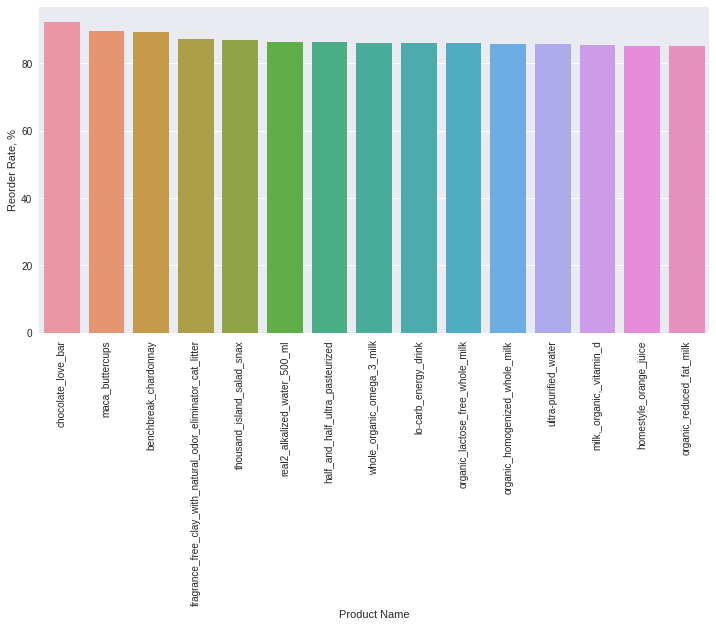

In [18]:
%%time
# consider products, purchased in more than X orders
order_limit = 100
top = 15

mo_products = order_details.groupby('product_id')[['reordered', 'order_id']]\
.aggregate({'reordered': sum, 'order_id': len}).reset_index()
mo_products.columns = ['product_id', 'reordered', 'order_cnt']

mo_products['reorder_rate'] = mo_products['reordered'] / mo_products['order_cnt']
mo_products = mo_products[mo_products.order_cnt > order_limit].sort_values(['reorder_rate'], 
                                                                           ascending=False)[:top]

mo_products = pd.merge(
    left=mo_products,
    right=goods,
    on='product_id')
mo_products

# plot it
plt.figure(figsize=(12, 6))
plt.xticks(rotation='vertical')
sns.barplot(mo_products.product_name, mo_products.reorder_rate*100)
plt.ylabel('Reorder Rate, %')
plt.xlabel('Product Name')
pass

### Orders, Split by Day of Week

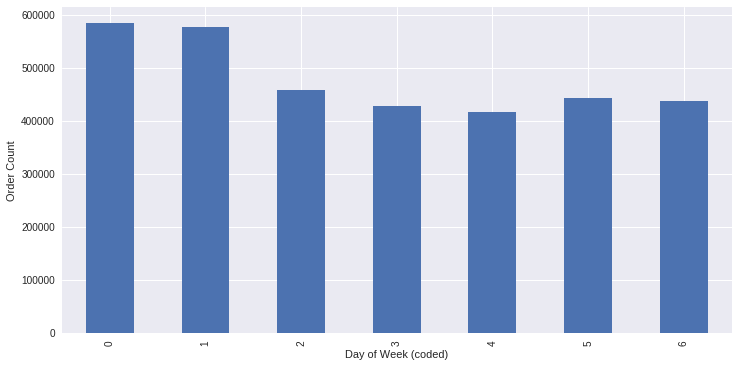

In [19]:
plt.figure(figsize=(12,6))
order_details.groupby('order_dow')['order_id'].apply(lambda x: len(x.unique())).plot(kind='bar')
plt.xticks(rotation='vertical')
plt.ylabel('Order Count')
plt.xlabel('Day of Week (coded)')
pass

### Orders, Split by Hour

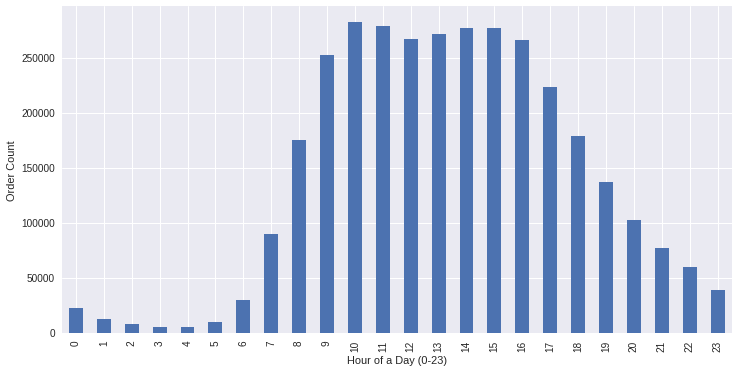

In [20]:
plt.figure(figsize=(12,6))
order_details.groupby('order_hour_of_day')['order_id'].apply(lambda x: 
                                                             len(x.unique())).plot(kind='bar')
plt.xticks(rotation='vertical')
plt.ylabel('Order Count')
plt.xlabel('Hour of a Day (0-23)')
pass

### Most Popular Departments

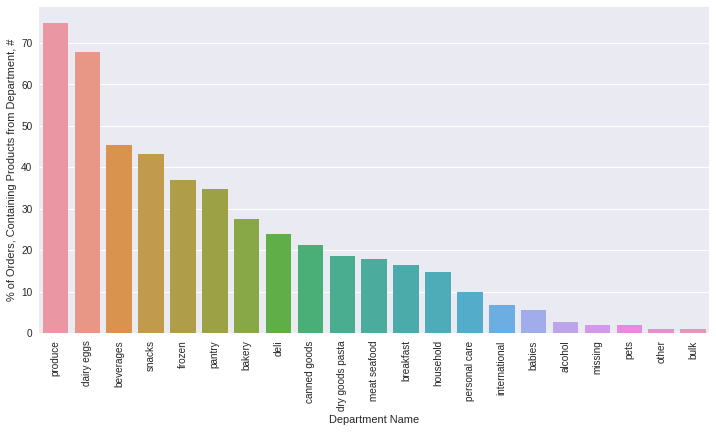

In [21]:
pop_dep = pd.merge(
    left=order_details.groupby('department_id')['order_id'].apply(lambda x: 
                                                                  len(x.unique())).reset_index(),
    right=goods[['department_id', 'department']].drop_duplicates(),
    how='inner',
    on='department_id'
).sort_values(['order_id'], ascending=False)

# plot it
total_orders = len(set(order_details.order_id))

plt.figure(figsize=(12, 6))
plt.xticks(rotation='vertical')
sns.barplot(pop_dep.department, pop_dep.order_id / total_orders * 100)
plt.ylabel('% of Orders, Containing Products from Department, #')
plt.xlabel('Department Name')
pass

### Most Popular Aisles

CPU times: user 5.85 s, sys: 3.26 s, total: 9.12 s
Wall time: 9.13 s


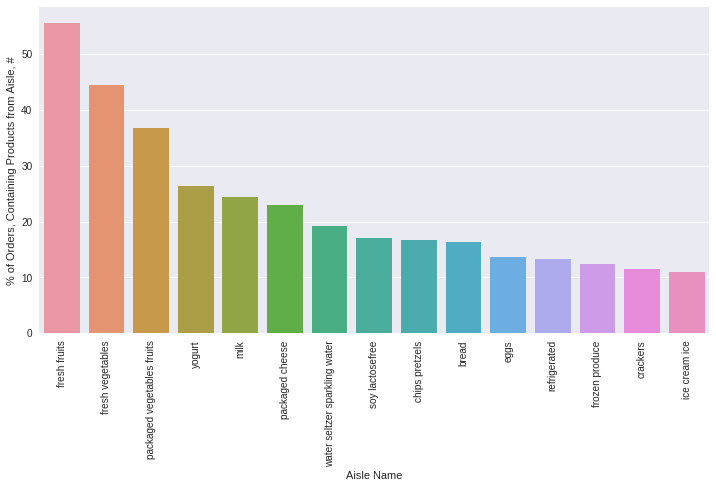

In [22]:
%%time
pop_ais = pd.merge(
    left=order_details.groupby('aisle_id')['order_id'].apply(lambda x: len(x.unique())).reset_index(),
    right=goods[['aisle_id', 'aisle']].drop_duplicates(),
    how='inner',
    on='aisle_id'
).sort_values(['order_id'], ascending=False)[:top]

# plot it
total_orders = len(set(order_details.order_id))

plt.figure(figsize=(12, 6))
plt.xticks(rotation='vertical')
sns.barplot(pop_ais.aisle, pop_ais.order_id / total_orders * 100)
plt.ylabel('% of Orders, Containing Products from Aisle, #')
plt.xlabel('Aisle Name')
pass

### Distribution of Order Count per User

Most common user made: 4 purchases
CPU times: user 19.1 s, sys: 5.75 s, total: 24.9 s
Wall time: 24.9 s


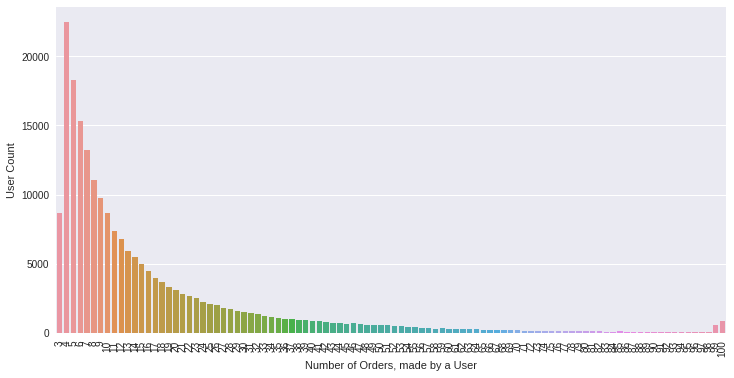

In [23]:
%%time
ocpu = order_details.groupby('user_id')['order_id']\
.apply(lambda x: len(x.unique())).reset_index().groupby('order_id').aggregate("count")

print('Most common user made: {} purchases'.format(
    ocpu[ocpu.user_id == ocpu.user_id.max()].index.values[0]))

plt.figure(figsize=(12, 6))
sns.barplot(ocpu.index, ocpu.user_id)
plt.xticks(rotation='vertical')
plt.ylabel('User Count')
plt.xlabel('Number of Orders, made by a User')
pass

### Days to Next Order

Most frequently next orders are made once in: 30 days
We clearly see monthly (>=30) and weekly (7) peaks
CPU times: user 3.13 s, sys: 8.56 s, total: 11.7 s
Wall time: 11.7 s


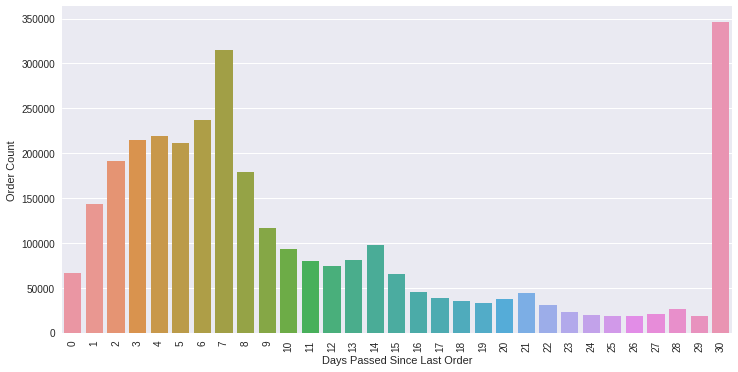

In [24]:
%%time
dtno = order_details.dropna(axis=0, 
                     subset=['days_since_prior_order']).groupby('order_id')['days_since_prior_order']\
.aggregate("mean").reset_index().apply(np.int32).groupby('days_since_prior_order').aggregate("count")

print('Most frequently next orders are made once in: {} days'.format(
    dtno[dtno.order_id == dtno.order_id.max()].index.values[0]))

print('We clearly see monthly (>=30) and weekly (7) peaks')

plt.figure(figsize=(12, 6))
sns.barplot(dtno.index, dtno.order_id)
plt.xticks(rotation='vertical')
plt.ylabel('Order Count')
plt.xlabel('Days Passed Since Last Order')
pass

### Time of last order vs. probability of reorder (also inspired by <a href="https://www.kaggle.com/philippsp/first-exploratory-analysis">This Kernel</a>)

We can see that longer lags leads to lowered probability (new items),
while same day orders tends to have more overlapped product list
CPU times: user 2.35 s, sys: 7.5 s, total: 9.85 s
Wall time: 9.85 s


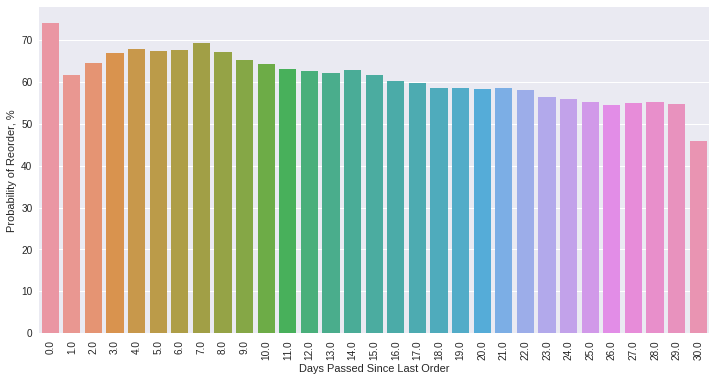

In [25]:
%%time

por = order_details.dropna(axis=0, subset=['days_since_prior_order'])\
.groupby('days_since_prior_order')['reordered'].aggregate("mean").reset_index()

print('We can see that longer lags leads to lowered probability (new items),\
\nwhile same day orders tends to have more overlapped product list')

plt.figure(figsize=(12, 6))
sns.barplot(por.days_since_prior_order, por.reordered*100)
plt.xticks(rotation='vertical')
plt.ylabel('Probability of Reorder, %')
plt.xlabel('Days Passed Since Last Order')
pass

### To Organic or not to Organic: That is the Question (also inspired by <a href="https://www.kaggle.com/philippsp/first-exploratory-analysis">This Kernel</a>)

CPU times: user 37.2 s, sys: 22.2 s, total: 59.5 s
Wall time: 59.5 s


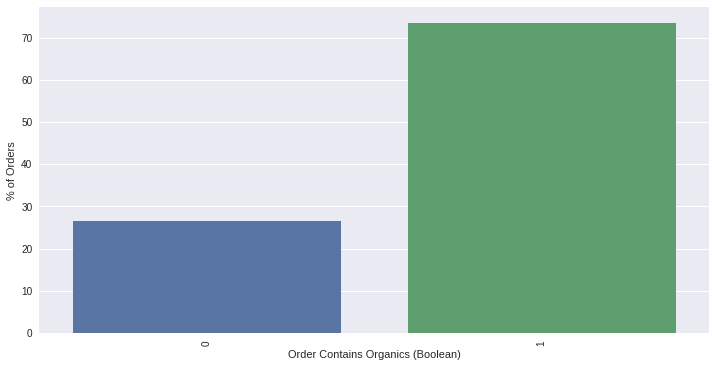

In [26]:
%%time

# share of organic/non-organic products and correspondent orders count
org = pd.merge(
    left=order_details[['product_id', 'order_id']],
    right=goods[['product_id', 'product_name']],
    how='left',
    on='product_id')

org['organic'] = org.product_name.str.contains('organic').astype(np.int8)
org = org.groupby('order_id')['organic'].aggregate("max").value_counts()

# plot it
plt.figure(figsize=(12, 6))
sns.barplot(org.index, org / org.sum() * 100)
plt.xticks(rotation='vertical')
plt.xlabel('Order Contains Organics (Boolean)')
plt.ylabel('% of Orders')
pass

### To be continued... 

**(TODO: test set explorations, purchase ordering, different visualizations etc.)**

### Stay tuned, this notebook will be updated on a regular basis
**P.s. Upvotes and comments would let me update it faster and in a more smart way :)**